In [1]:
from gurobipy import *
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt

# Testing

In [262]:
output_file = 'variable_values_e'


In [263]:
results = pd.read_table(f'../output/{output_file}.txt')
n = results[results["results"].str.contains("n")]
u = results[results["results"].str.contains("u")]
c = results[results["results"].str.contains("c")]
varn = n['results'].str.split('=').apply(lambda x: x[0])
valn = n['results'].str.split('=').apply(lambda x: x[1])
t = varn.str.split('n').apply(lambda x: ast.literal_eval(x[1])).apply(lambda x: x[0])
i = varn.str.split('n').apply(lambda x: ast.literal_eval(x[1])).apply(lambda x: x[1])
k = varn.str.split('n').apply(lambda x: ast.literal_eval(x[1])).apply(lambda x: x[2])
amount = valn
specificn = pd.DataFrame(np.array([t,i,k,amount]).T).reset_index(drop=True)
specificn.columns = ['t','i', 'k', 'amount']
specificn['name'] = 'n'

varu = u['results'].str.split('=').apply(lambda x: x[0])
valu = u['results'].str.split('=').apply(lambda x: x[1])
t = varu.str.split('u').apply(lambda x: ast.literal_eval(x[1])).apply(lambda x: x[0])
i = varu.str.split('u').apply(lambda x: ast.literal_eval(x[1])).apply(lambda x: x[1])
j = varu.str.split('u').apply(lambda x: ast.literal_eval(x[1])).apply(lambda x: x[2])
k = varu.str.split('u').apply(lambda x: ast.literal_eval(x[1])).apply(lambda x: x[3])
amount = valu
specificu = pd.DataFrame(np.array([t,i,j,k,amount]).T).reset_index(drop=True)
specificu.columns = ['t','i', 'j', 'k', 'amount']
specificu['name'] = 'u'

varc = c['results'].str.split('=').apply(lambda x: x[0])
valc = c['results'].str.split('=').apply(lambda x: x[1])
t = varc.str.split('c').apply(lambda x: ast.literal_eval(x[1])).apply(lambda x: x[0])
i = varc.str.split('c').apply(lambda x: ast.literal_eval(x[1])).apply(lambda x: x[1])
x = varc.str.split('c').apply(lambda x: ast.literal_eval(x[1])).apply(lambda x: x[2])
y = varc.str.split('c').apply(lambda x: ast.literal_eval(x[1])).apply(lambda x: x[3])
amount = valc
specificc = pd.DataFrame(np.array([t,i,x,y,amount]).T).reset_index(drop=True)
specificc.columns = ['t','i', 'x', 'y', 'amount']
specificc['name'] = 'c'
specificn['amount'] = specificn['amount'].astype(float)
specificu['amount'] = specificu['amount'].astype(float)
specificc['amount'] = specificc['amount'].astype(float)


In [264]:
specificu01 = specificu[specificu['i'] == 0].reset_index(drop=True)
specificu10 = specificu[specificu['i'] == 1].reset_index(drop=True)

specificc01 = specificc[specificc['i'] == 0].reset_index(drop=True)
specificc10 = specificc[specificc['i'] == 1].reset_index(drop=True)

specificn01 = specificn[specificn['i'] == 0].reset_index(drop=True)
specificn10 = specificn[specificn['i'] == 1].reset_index(drop=True)


In [265]:
gamma = [3.237872699, 3.729470167, 4.404786588, 5.379957014, 6.913363091,
        9.685271742, 16.30528373, 71.41103553]
gamma = np.array(gamma) / 5
gamma = np.ceil(gamma)

In [266]:
end = specificc['t'].max()
all_c = np.zeros(shape=(1,end), dtype=int)
for i in range(specificc.shape[0]):
    val = int(specificc['amount'][i])
    soc0 = int(specificc['x'][i])
    soc1 = int(specificc['y'][i])
    t = int(specificc['t'][i])
    time_charge = int(gamma[soc0: soc1].sum())
    occupied = np.zeros(shape=(val,end))
    for j in range(val):
        occupied[j][t:t+time_charge] = 1

    all_c = np.concatenate([all_c, occupied], axis=0)
all_c = all_c[1:,:]

all_u = np.zeros(shape=(1,end), dtype=int)
for i in range(specificu.shape[0]):
    val = int(specificu['amount'][i])
    t = int(specificu['t'][i])
    flight_time = 2
    flight = np.zeros(shape=(val,end))
    for j in range(val):
        flight[j][t:t+flight_time] = 1

    all_u = np.concatenate([all_u, flight], axis=0)
all_u = all_u[1:,:]


all_n = np.zeros(shape=(1,end+2), dtype=int)
for i in range(specificn.shape[0]):
    val = int(specificn['amount'][i])
    t = int(specificn['t'][i])
    idle = np.zeros(shape=(val,end+2))
    for j in range(val):
        idle[j][t] = 1
    all_n = np.concatenate([all_n, idle], axis=0)
all_n = all_n[1:,:-1]

IndexError: index 1152 is out of bounds for axis 0 with size 1149

In [164]:
def calculate_num_aircrafts(specificc, specificu, specificn):
    end = specificc['t'].max()
    all_c = np.zeros(shape=(1,end), dtype=int)
    for i in range(specificc.shape[0]):
        val = int(specificc['amount'][i])
        soc0 = int(specificc['x'][i])
        soc1 = int(specificc['y'][i])
        t = int(specificc['t'][i])
        time_charge = int(gamma[soc0: soc1].sum())
        occupied = np.zeros(shape=(val,end))
        for j in range(val):
            occupied[j][t:t+time_charge] = 1

        all_c = np.concatenate([all_c, occupied], axis=0)
    all_c = all_c[1:,:]

    all_u = np.zeros(shape=(1,end), dtype=int)
    for i in range(specificu.shape[0]):
        val = int(specificu['amount'][i])
        t = int(specificu['t'][i])
        flight_time = 2
        flight = np.zeros(shape=(val,end))
        for j in range(val):
            flight[j][t:t+flight_time] = 1

        all_u = np.concatenate([all_u, flight], axis=0)
    all_u = all_u[1:,:]


    all_n = np.zeros(shape=(1,end+2), dtype=int)
    for i in range(specificn.shape[0]):
        val = int(specificn['amount'][i])
        t = int(specificn['t'][i])
        idle = np.zeros(shape=(val,end+2))
        for j in range(val):
            idle[j][t] = 1
        all_n = np.concatenate([all_n, idle], axis=0)
    all_n = all_n[1:,:-1]

    return all_c, all_n, all_u

In [165]:
lax_all_c, lax_all_n, lax_all_u = calculate_num_aircrafts(specificc01, specificn01, specificu01)

In [166]:
dtla_all_c, dtla_all_n, dtla_all_u = calculate_num_aircrafts(specificc10, specificn10, specificu10)

In [174]:
all_c, all_n, all_u = calculate_num_aircrafts(specificc, specificn, specificu)

[Text(0.5, 1.0, 'State of Aircrafts at LAX')]

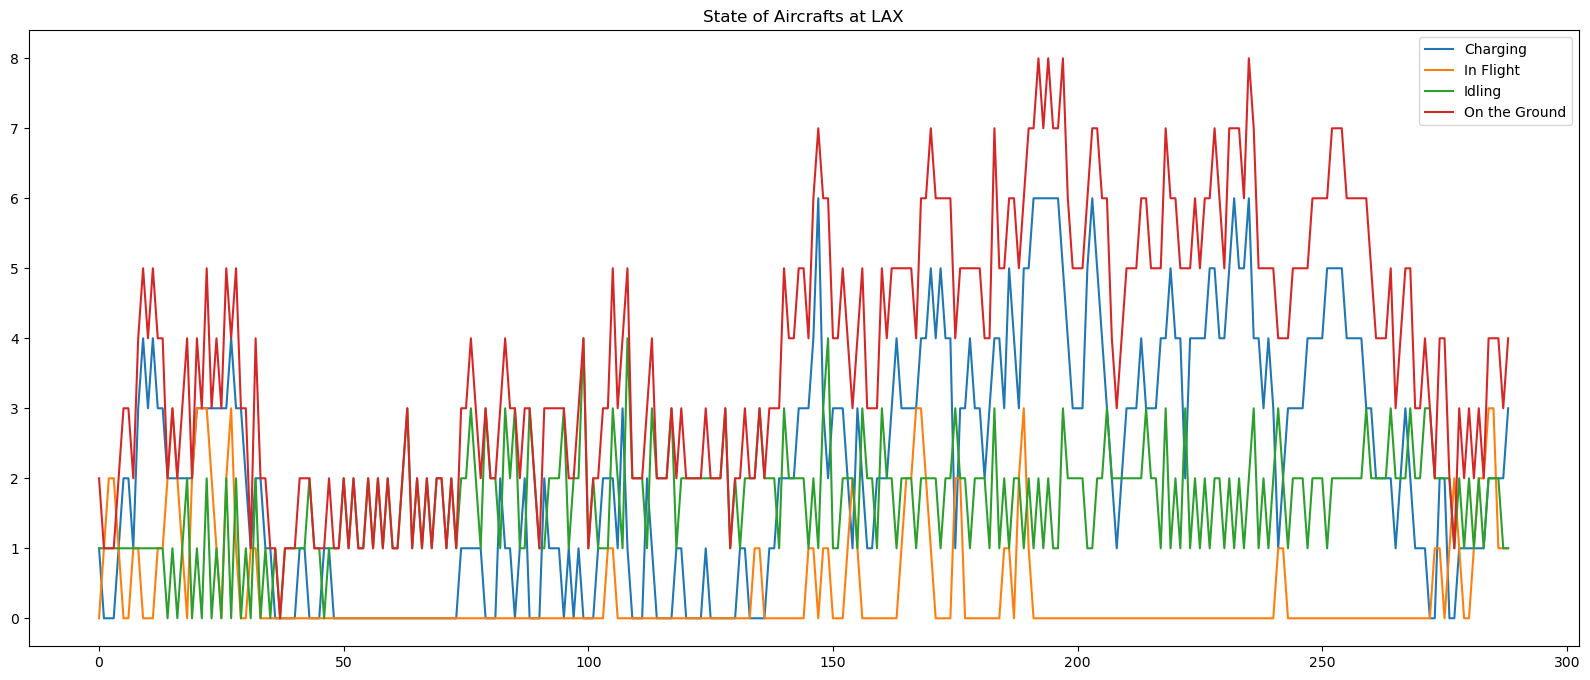

In [238]:
import seaborn as sns
import matplotlib.pyplot as plt
x0 = 144+288
x1 = 144+288*2+1

fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(lax_all_c.sum(axis=0)[x0:x1], label='Charging', ax=ax)
sns.lineplot(lax_all_u.sum(axis=0)[x0:x1], label='In Flight', ax=ax)
sns.lineplot(lax_all_n.sum(axis=0)[x0:x1], label='Idling', ax=ax)
sns.lineplot((lax_all_c.sum(axis=0)[x0:x1] + lax_all_n.sum(axis=0)[x0:x1]), label='On the Ground', ax=ax)
ax.set(title='State of Aircrafts at LAX')

[Text(0.5, 1.0, 'State of Aircrafts at DTLA')]

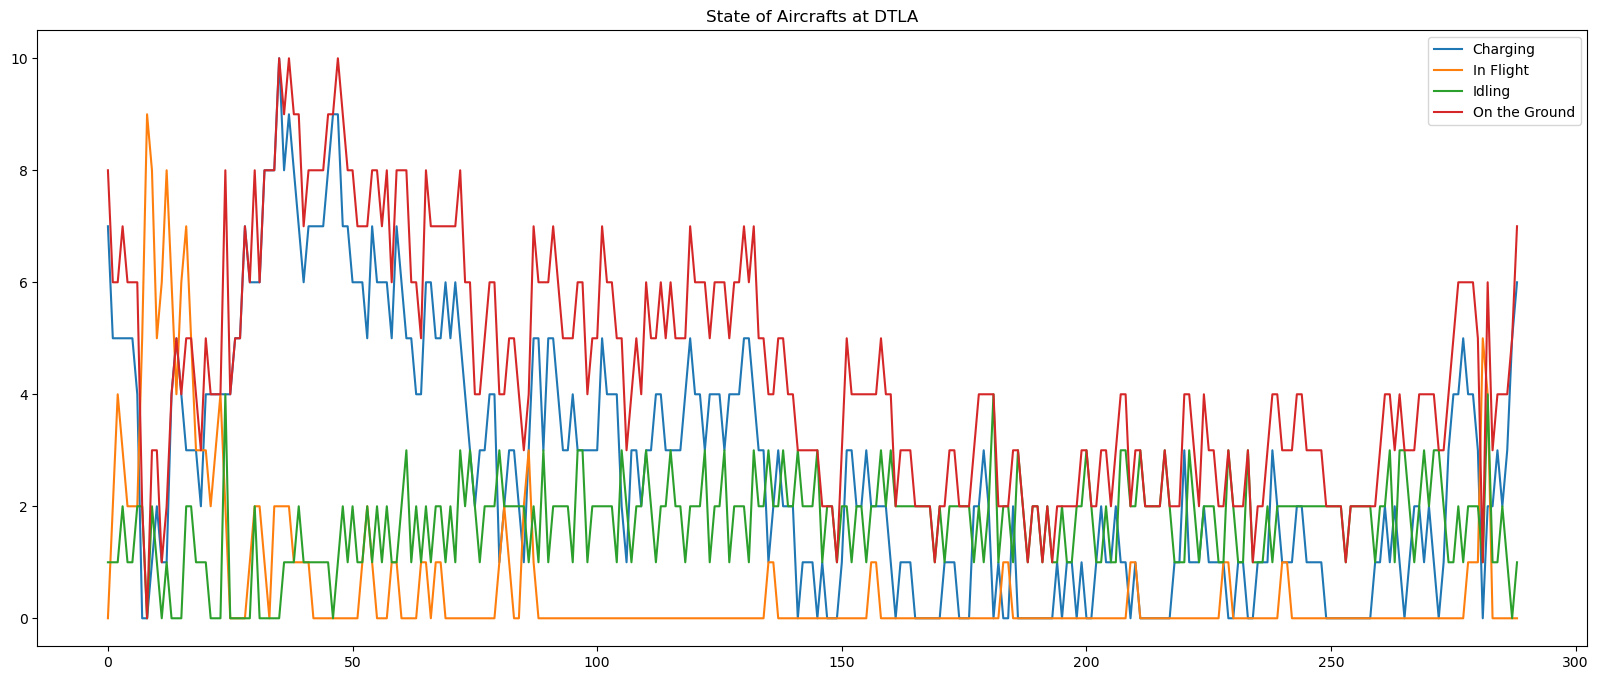

In [171]:
import seaborn as sns
import matplotlib.pyplot as plt
x0 = 144+288
x1 = 144+288*2+1

fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(dtla_all_c.sum(axis=0)[x0:x1], label='Charging', ax=ax)
sns.lineplot(dtla_all_u.sum(axis=0)[x0:x1], label='In Flight', ax=ax)
sns.lineplot(dtla_all_n.sum(axis=0)[x0:x1], label='Idling', ax=ax)
sns.lineplot((dtla_all_c.sum(axis=0)[x0:x1] + dtla_all_n.sum(axis=0)[x0:x1]), label='On the Ground', ax=ax)
ax.set(title='State of Aircrafts at DTLA')

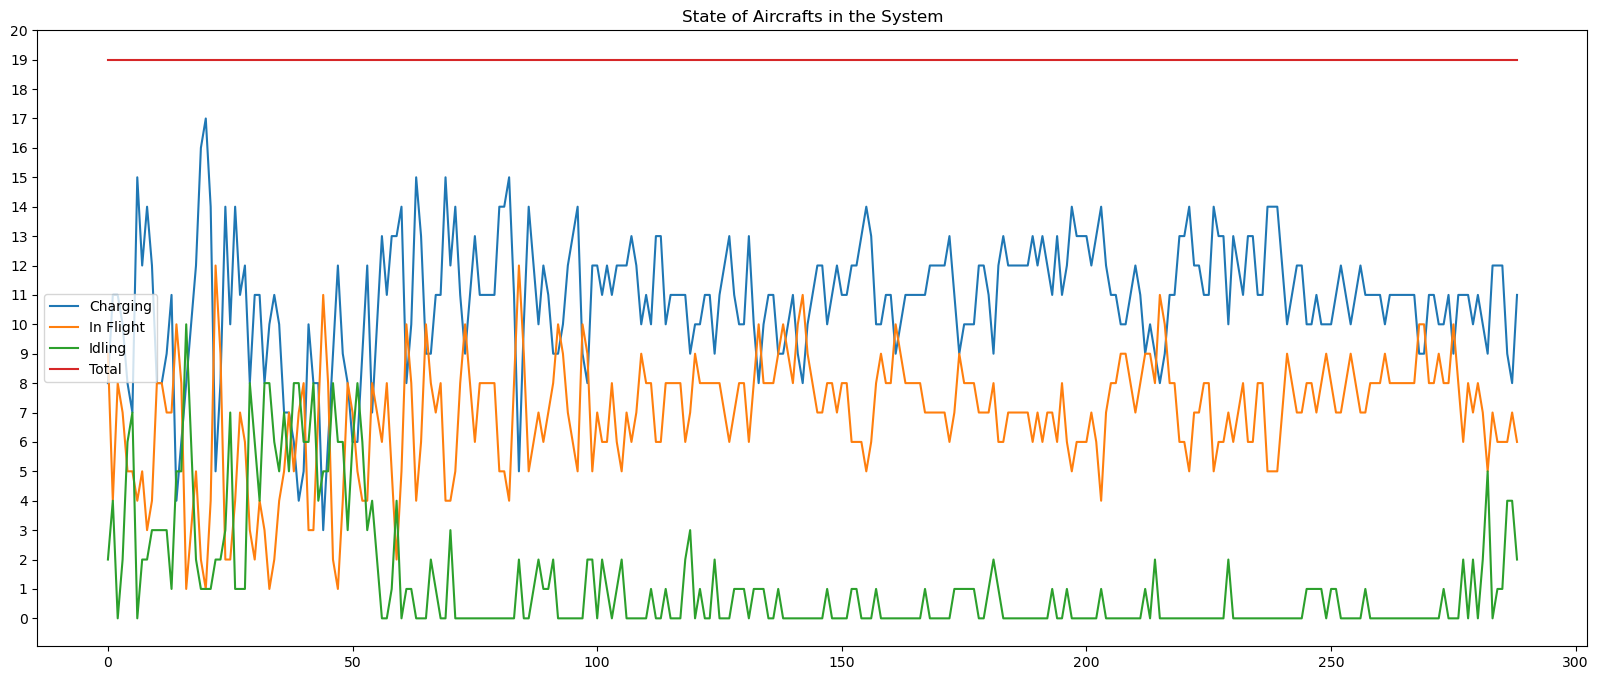

In [191]:
import seaborn as sns
import matplotlib.pyplot as plt
x0 = 144+288
x1 = 144+288*2+1

fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(all_c.sum(axis=0)[x0:x1], label='Charging', ax=ax)
sns.lineplot(all_u.sum(axis=0)[x0:x1], label='In Flight', ax=ax)
sns.lineplot(all_n.sum(axis=0)[x0:x1], label='Idling', ax=ax)
sns.lineplot((all_c.sum(axis=0)[x0:x1] + all_u.sum(axis=0)[x0:x1] + all_n.sum(axis=0)[x0:x1]), label='Total', ax=ax)
ax.set(title='State of Aircrafts in the System', yticks=np.arange(21));

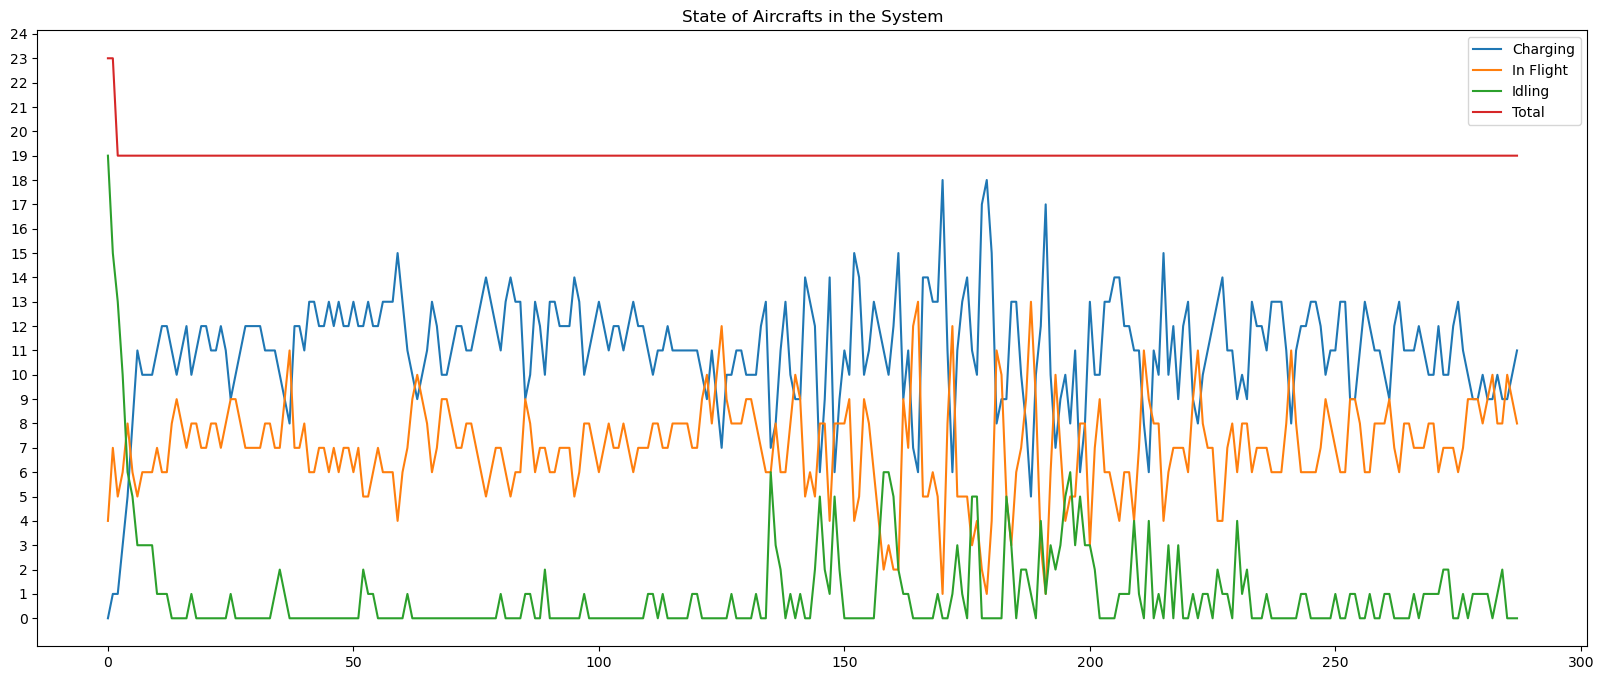

In [268]:
import seaborn as sns
import matplotlib.pyplot as plt
x0 = 144+288
x1 = 144+288*2+1

x0 = 0
x1 = 288

fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(all_c.sum(axis=0)[x0:x1], label='Charging', ax=ax)
sns.lineplot(all_u.sum(axis=0)[x0:x1], label='In Flight', ax=ax)
sns.lineplot(all_n.sum(axis=0)[x0:x1], label='Idling', ax=ax)
sns.lineplot((all_c.sum(axis=0)[x0:x1] + all_u.sum(axis=0)[x0:x1] + all_n.sum(axis=0)[x0:x1]), label='Total', ax=ax)
ax.set(title='State of Aircrafts in the System', yticks=np.arange(25));

In [250]:
all_n.shape

(1133, 1147)

In [275]:
display(all_c.sum(axis=0)[144])
display(all_u.sum(axis=0)[144])
display(all_n.sum(axis=0)[144])

12.0

5.0

2.0

In [274]:
display(all_c.sum(axis=0)[144+288])
display(all_u.sum(axis=0)[144+288])
display(all_n.sum(axis=0)[144+288])

8.0

9.0

2.0

<Axes: >

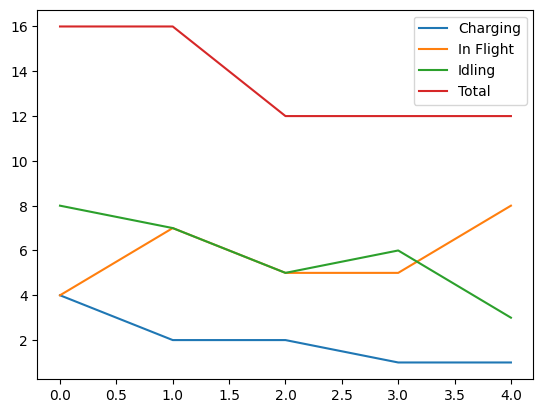

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
sns.lineplot(all_c.sum(axis=0)[:5], label='Charging', ax=ax)
sns.lineplot(all_u.sum(axis=0)[:5], label='In Flight', ax=ax)
sns.lineplot(all_n.sum(axis=0)[:5], label='Idling', ax=ax)
sns.lineplot((all_c.sum(axis=0)[:5] + all_u.sum(axis=0)[:5]+all_n.sum(axis=0)[:5]), label='Total', ax=ax)

In [86]:
gamma[soc0: soc1].sum()

2.0

In [29]:
gamma

array([ 1.,  1.,  1.,  2.,  2.,  2.,  4., 15.])

In [7]:
gamma = [3.237872699, 3.729470167, 4.404786588, 5.379957014, 6.913363091,
        9.685271742, 16.30528373, 71.41103553]
gamma = np.array(gamma) / 5
gamma = np.ceil(gamma)

In [34]:
import pandas as pd

In [ ]:
data = pd.read_csv('../input/schedule.csv')
LAX_DTLA = data[data['od'] == 'LAX_DTLA']
DTLA_LAX = data[data['od'] == 'DTLA_LAX']
# Create the list of lists
LAX_DTLA = [[1 if i in LAX_DTLA['schedule'].tolist() else 0] for i in range(1440)]
DTLA_LAX = [[1 if i in DTLA_LAX['schedule'].tolist() else 0] for i in range(1440)]

# Reshape the array
new_array_LAX_DTLA = np.array(LAX_DTLA).reshape((288, 5))
new_array_DTLA_LAX = np.array(DTLA_LAX).reshape((288, 5))
# Convert back to list
new_array_LAX_DTLA = new_array_LAX_DTLA.tolist()
new_array_DTLA_LAX = new_array_DTLA_LAX.tolist()
# Add elements within each cell
new_array_LAX_DTLA_sum = np.sum(new_array_LAX_DTLA, axis=1)
new_array_DTLA_LAX_sum = np.sum(new_array_DTLA_LAX, axis=1)

LAX_DTLA = new_array_LAX_DTLA_sum # Binary flight schedule for 5-mins intervals
DTLA_LAX = new_array_DTLA_LAX_sum

In [77]:
schedule = pd.read_csv('../input/schedule.csv')
schedule['schedule'] = schedule['schedule'] // 5 * 5
schedule[schedule['od'] == 'LAX_DTLA']

u_lax_dtla = []
u_dtla_lax = []
for i in range(0,1440,5):
    id = schedule[(schedule['od'] == 'LAX_DTLA') & (schedule['schedule'] == i)]
    u_lax_dtla.append(id.shape[0])
    id = schedule[(schedule['od'] == 'DTLA_LAX') & (schedule['schedule'] == i)]
    u_dtla_lax.append(id.shape[0])
u_lax_dtla = np.array(u_lax_dtla)
u_dtla_lax = np.array(u_dtla_lax)

In [ ]:
# Data from specificu
specificu_t01 = list(specificu01['t'])
specificu_amount01 = list(specificu01['amount'])
specificu_t10 = list(specificu10['t'])
specificu_amount10 = list(specificu10['amount'])


In [55]:
lax_dtla_repositioning = pd.DataFrame({'t':specificu_t01, 'lax_dtla':specificu_amount01})
lax_dtla_repositioning.to_csv('lax_dtla_repositioning.csv', index=False)
dtla_lax_repositioning = pd.DataFrame({'t':specificu_t10, 'lax_dtla':specificu_amount10})
dtla_lax_repositioning.to_csv('dtla_lax_repositioning.csv', index=False)

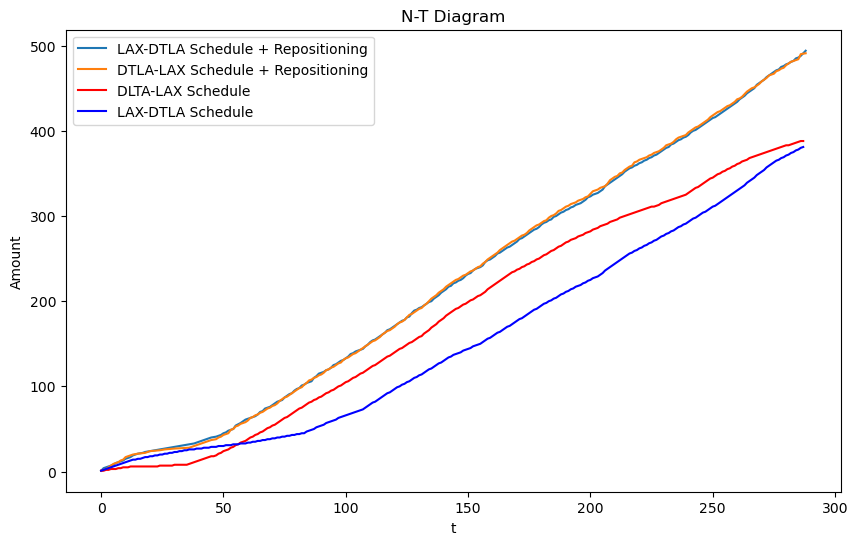

In [59]:

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(specificu_t01, np.cumsum(specificu_amount01), label='LAX-DTLA Schedule + Repositioning')
plt.plot(specificu_t10, np.cumsum(specificu_amount10), label='DTLA-LAX Schedule + Repositioning')
plt.plot(np.cumsum(u_dtla_lax),color='red', label='DLTA-LAX Schedule')
plt.plot(np.cumsum(u_lax_dtla),color='blue', label='LAX-DTLA Schedule')
plt.xlabel('t')
plt.ylabel('Amount')
plt.title('N-T Diagram')
plt.legend()
plt.show()


In [25]:


# Data from specificn
specificn_t = list(specificn['t'])
specificn_amount = list(specificn['amount'])

# Data from specificu
specificu_t = list(specificu['t'])
specificu_amount = list(specificu['amount'])

# Data from specificc
specificc_t = list(specificc['t'])
specificc_amount = list(specificc['amount'])

In [ ]:
class aircraft:
    def __init__(self, tail_number, soc, status):
        self.tail_number = tail_number
        self.soc = soc
        self.status = status
        self.time_remaining_to_charge = 0
        self.time_remaining_in_flight = 0
        self.timestep = 0
        self.tasks = np.empty(shape=(1,))


    def assignment(self, flight=None, charging=None, idling=None):
        if flight is not None:
            self.timestep += 2
            self.tasks = np.concatenate([self.tasks, np.repeat(np.array([flight]),2)], axis=1)

        if charging is not None:
            soc0, soc1 = charging
            charging_time = int(gamma[soc0: soc1].sum())
            self.timestep += charging_time
            charging_task = np.repeat(np.array([str(soc0) + str(soc1)]), charging_time)
            self.tasks = np.concatenate([self.tasks, charging_task], axis=1)
        
        if idling is not None:
            self.timestep += 1
            self.taks = np.concatenate([self.tasks, np.array([idling])], axis=1)
    
    def check_status(self, status, soc, timestep):
        if self.status == status:
            if self.soc == soc:
                if self.timestep == timestep:
                    return True



for i in range(10):
    lax_dtla_u = specificu[(specificu['t'] == i) & (specificu['i'] == 0)]
    dtla_lax_u = specificu[(specificu['t'] == i) & (specificu['i'] == 1)]
    if lax_dtla_u.shape[0] != 0:
        
